##ResNet50

- IMG_SIZE = 32
- BATCH_SIZE = 32
- EPOCHS = 30
- Lr = 0.0001

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import ResNet50
import tensorflow as tf
import tensorflow.keras as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models

Mounted at /content/drive


In [ ]:
# Define paths to dataset directories
train_dir = '/content/drive/My Drive/Data/GTSRB/Train/GTSRB/Final_Training/Images/'
test_dir = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/'

# Define image size
IMG_SIZE = 32  # Resize images
BATCH_SIZE = 32
num_classes = 43

# Helper function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    # Loop through each subdirectory (which corresponds to a class)
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)

        if os.path.isdir(label_path):
            label = int(label_dir)  # Subdirectory name is the class label

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Check if the file has a valid image extension
                _, file_extension = os.path.splitext(img_file)
                if file_extension.lower() not in valid_extensions:
                    print(f"Skipping non-image file: {img_file}")
                    continue  # Skip non-image files (e.g., CSV)

                # Read the image using OpenCV
                image = cv2.imread(img_path)

                # Resize image
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the image and label to the lists
                images.append(image)
                labels.append(label)

    # Convert to NumPy arrays and normalize
    images = np.array(images, dtype='float32') / 255.0  # Normalize images
    labels = to_categorical(labels, num_classes)  # One-hot encode labels

    return images, labels

# Load training data
images, labels = load_data(train_dir)

Skipping non-image file: GT-00000.csv
Skipping non-image file: GT-00001.csv
Skipping non-image file: GT-00002.csv
Skipping non-image file: GT-00003.csv
Skipping non-image file: GT-00004.csv
Skipping non-image file: GT-00005.csv
Skipping non-image file: GT-00006.csv
Skipping non-image file: GT-00007.csv
Skipping non-image file: GT-00008.csv
Skipping non-image file: GT-00009.csv
Skipping non-image file: GT-00010.csv
Skipping non-image file: GT-00011.csv
Skipping non-image file: GT-00012.csv
Skipping non-image file: GT-00013.csv
Skipping non-image file: GT-00014.csv
Skipping non-image file: GT-00015.csv
Skipping non-image file: GT-00016.csv
Skipping non-image file: GT-00017.csv
Skipping non-image file: GT-00018.csv
Skipping non-image file: GT-00019.csv
Skipping non-image file: GT-00020.csv
Skipping non-image file: GT-00021.csv
Skipping non-image file: GT-00022.csv
Skipping non-image file: GT-00023.csv
Skipping non-image file: GT-00024.csv
Skipping non-image file: GT-00025.csv
Skipping non

In [ ]:
train_images, train_labels = images, labels

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (31367, 32, 32, 3)
Validation data shape: (7842, 32, 32, 3)


##Visualization

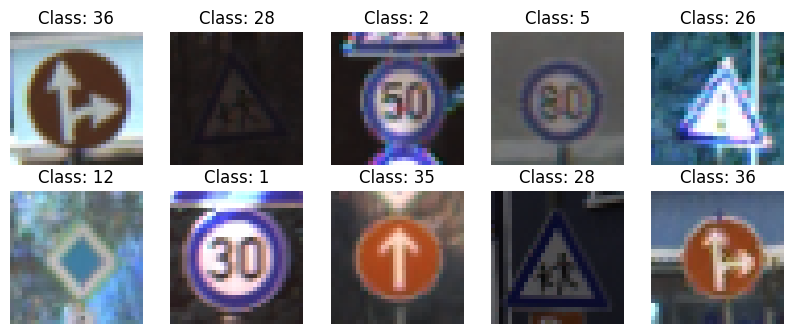

In [ ]:
import matplotlib.pyplot as plt

# Function to plot images
def plot_images(images, labels, num=10):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.show()

# Plot training images
plot_images(X_train, y_train)

In [ ]:
### Image Augmentation ###
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=15,        # Rotate images by up to 15 degrees
    zoom_range=0.2,           # Random zoom in/out by up to 20%
    width_shift_range=0.1,    # Shift the image horizontally by 10%
    height_shift_range=0.1,   # Shift the image vertically by 10%
    #horizontal_flip=True,     # Randomly flip images horizontally
)

# Fit the generator on the training data
datagen.fit(X_train)

# Create the augmented data generator for training
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)

##Visualization of Augmented Images

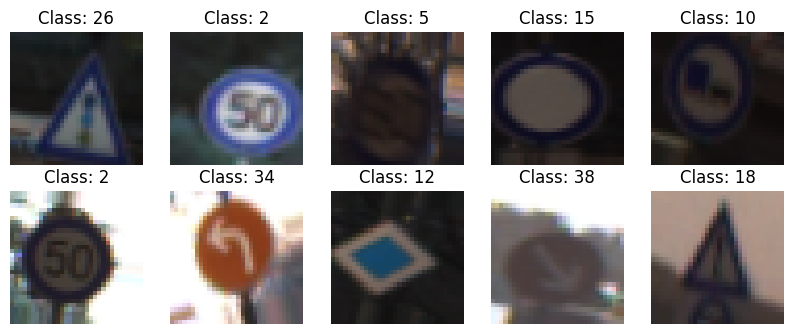

In [ ]:
import matplotlib.pyplot as plt

# Visualize some augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot some examples
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f'Class: {np.argmax(augmented_labels[i])}')
    plt.axis('off')
plt.show()

## Load test data

In [ ]:
# Load the test dataset
def load_test_data(test_dir):
    images = []
    img_names = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)

        # Check if the file is an image
        _, file_extension = os.path.splitext(img_file)
        if file_extension.lower() not in valid_extensions:
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip non-image files

        # Read and resize the image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Append the image and image file name to the lists
        images.append(image)
        img_names.append(img_file)

    # Convert images to a NumPy array
    images = np.array(images, dtype='float32') / 255.0  # Normalize images

    return images, img_names

# Load test images
X_test, test_img_names = load_test_data(test_dir)

Skipping non-image file: GT-final_test.test.csv


##Load ResNet50 Model

In [ ]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Create a sequential model
model = models.Sequential()

# Add the ResNet50 base model to the sequential model
model.add(base_model)

#Add exta layers on top of it
model.add(layers.Flatten())
model.add(layers.BatchNormalization())

# Add a dense layer with 256 units and ReLU activation function
model.add(layers.Dense(256, activation='relu'))
# Add dropout layer with a rate of 0.5 to prevent overfitting
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

# Add a dense layer with 128 units and ReLU activation function
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

# Add a dense layer with 64 units and ReLU activation function
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

# Add the output layer with softmax activation function for multi-class classification
model.add(layers.Dense(num_classes, activation='softmax'))

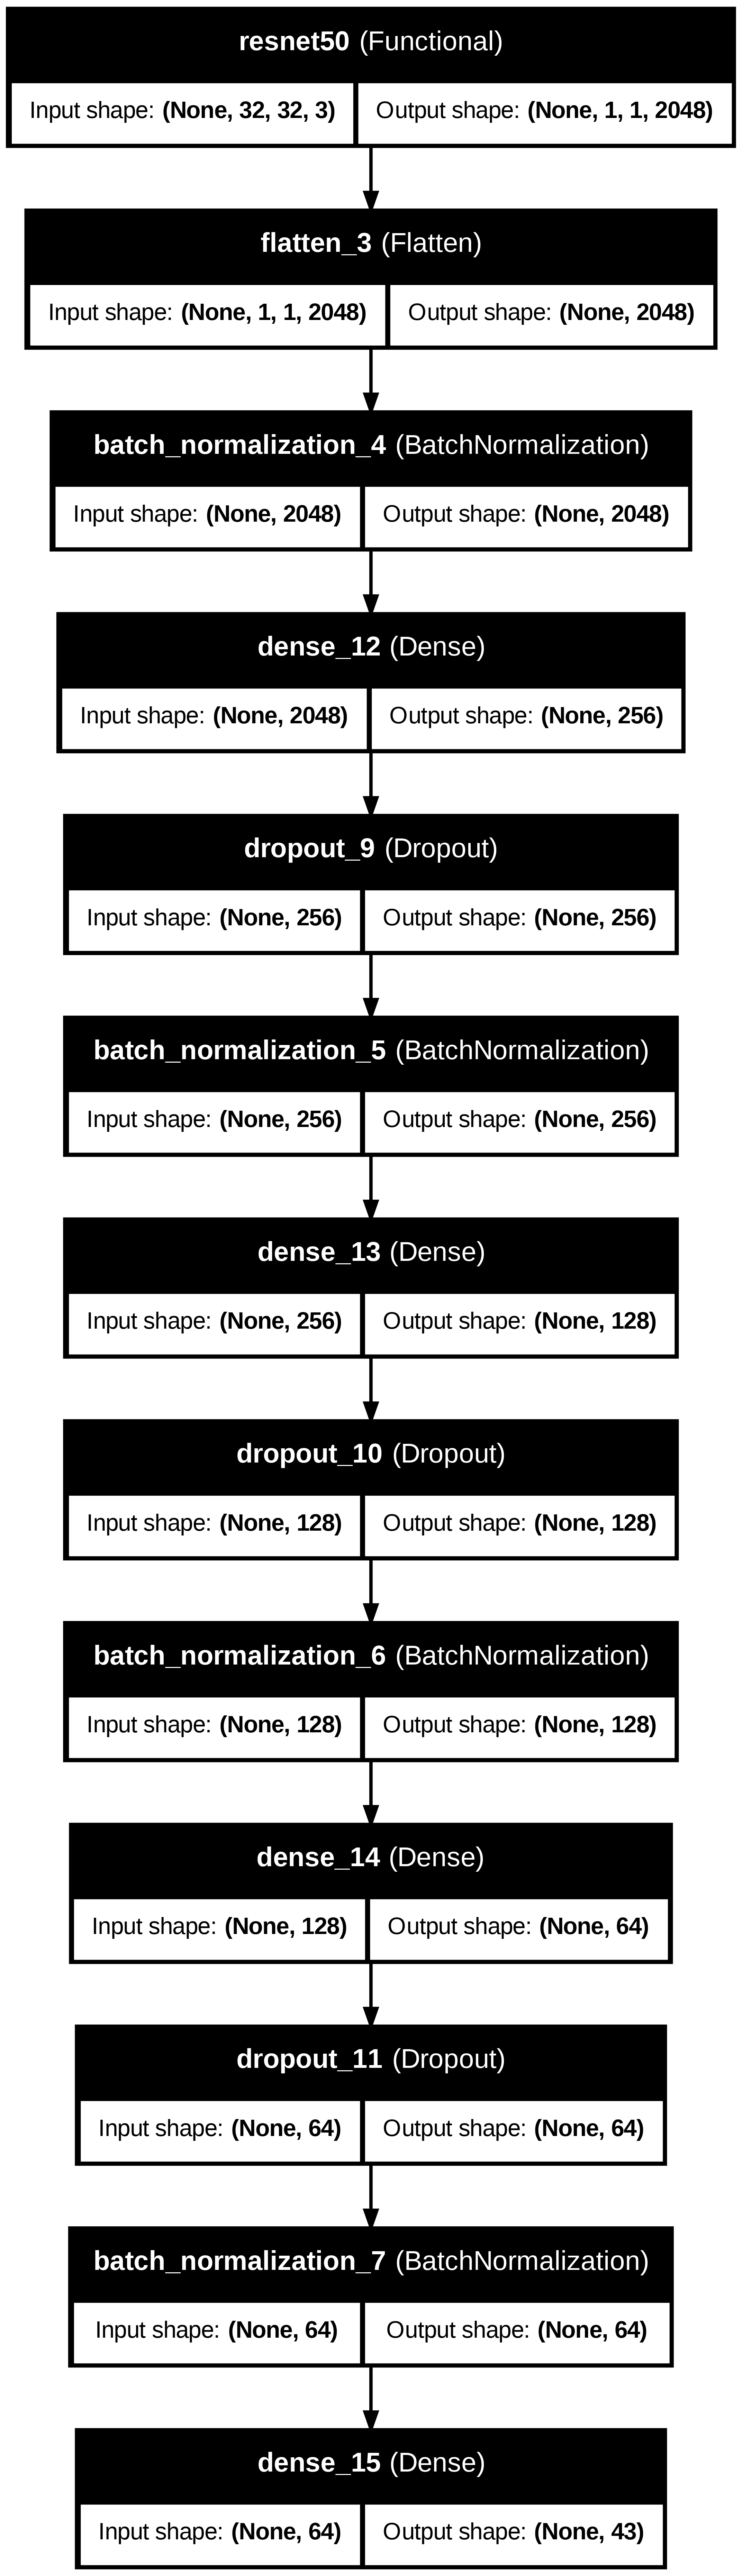

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the augmented data generator
history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=30, steps_per_epoch=len(X_train) // BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 138s 79ms/step - accuracy: 0.0359 - loss: 4.1454 - val_accuracy: 0.1947 - val_loss: 3.1667
Epoch 2/30
  1/980 ━━━━━━━━━━━━━━━━━━━━ 55s 57ms/step - accuracy: 0.0625 - loss: 3.6335

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0625 - loss: 3.6335 - val_accuracy: 0.1948 - val_loss: 3.1650
Epoch 3/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.1541 - loss: 3.3609 - val_accuracy: 0.3878 - val_loss: 2.2617
Epoch 4/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0938 - loss: 3.4342 - val_accuracy: 0.3863 - val_loss: 2.2599
Epoch 5/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 49s 50ms/step - accuracy: 0.2552 - loss: 2.7994 - val_accuracy: 0.4992 - val_loss: 1.8502
Epoch 6/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3750 - loss: 2.3625 - val_accuracy: 0.4997 - val_loss: 1.8482
Epoch 7/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 75s 45ms/step - accuracy: 0.3431 - loss: 2.3790 - val_accuracy: 0.5696 - val_loss: 1.5056
Epoch 8/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2500 - loss: 2.4201 - val_accuracy: 0.5700 - val_loss: 1.5054
Epoch 9/30
980/980 ━━━━━━━━━━━━━━━━━━━━ 79s 44ms/step - accuracy: 0.4272 - loss: 2.0607 - val_accuracy: 0.627

##Accuracy and Loss Curves
Visualisation of loss and accuracy over time (epochs).

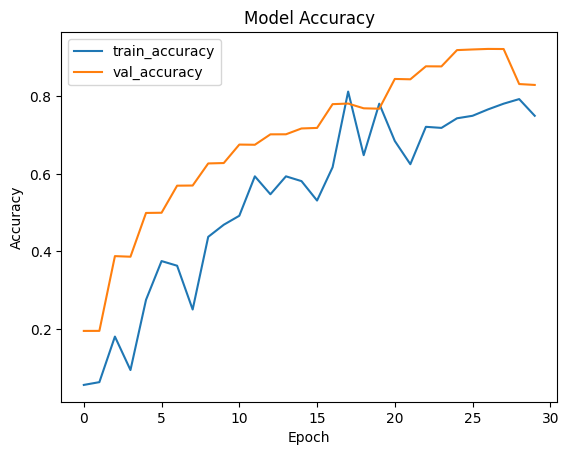

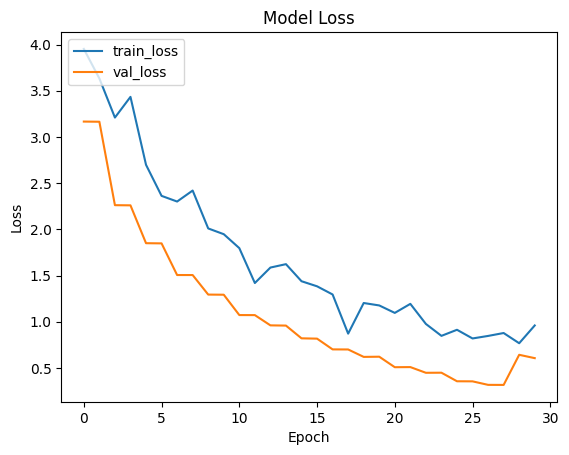

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f'Test accuracy: {test_acc}')

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9272 - loss: 0.3115
Test accuracy: 0.9223412275314331


##Confusion Matrix

246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step


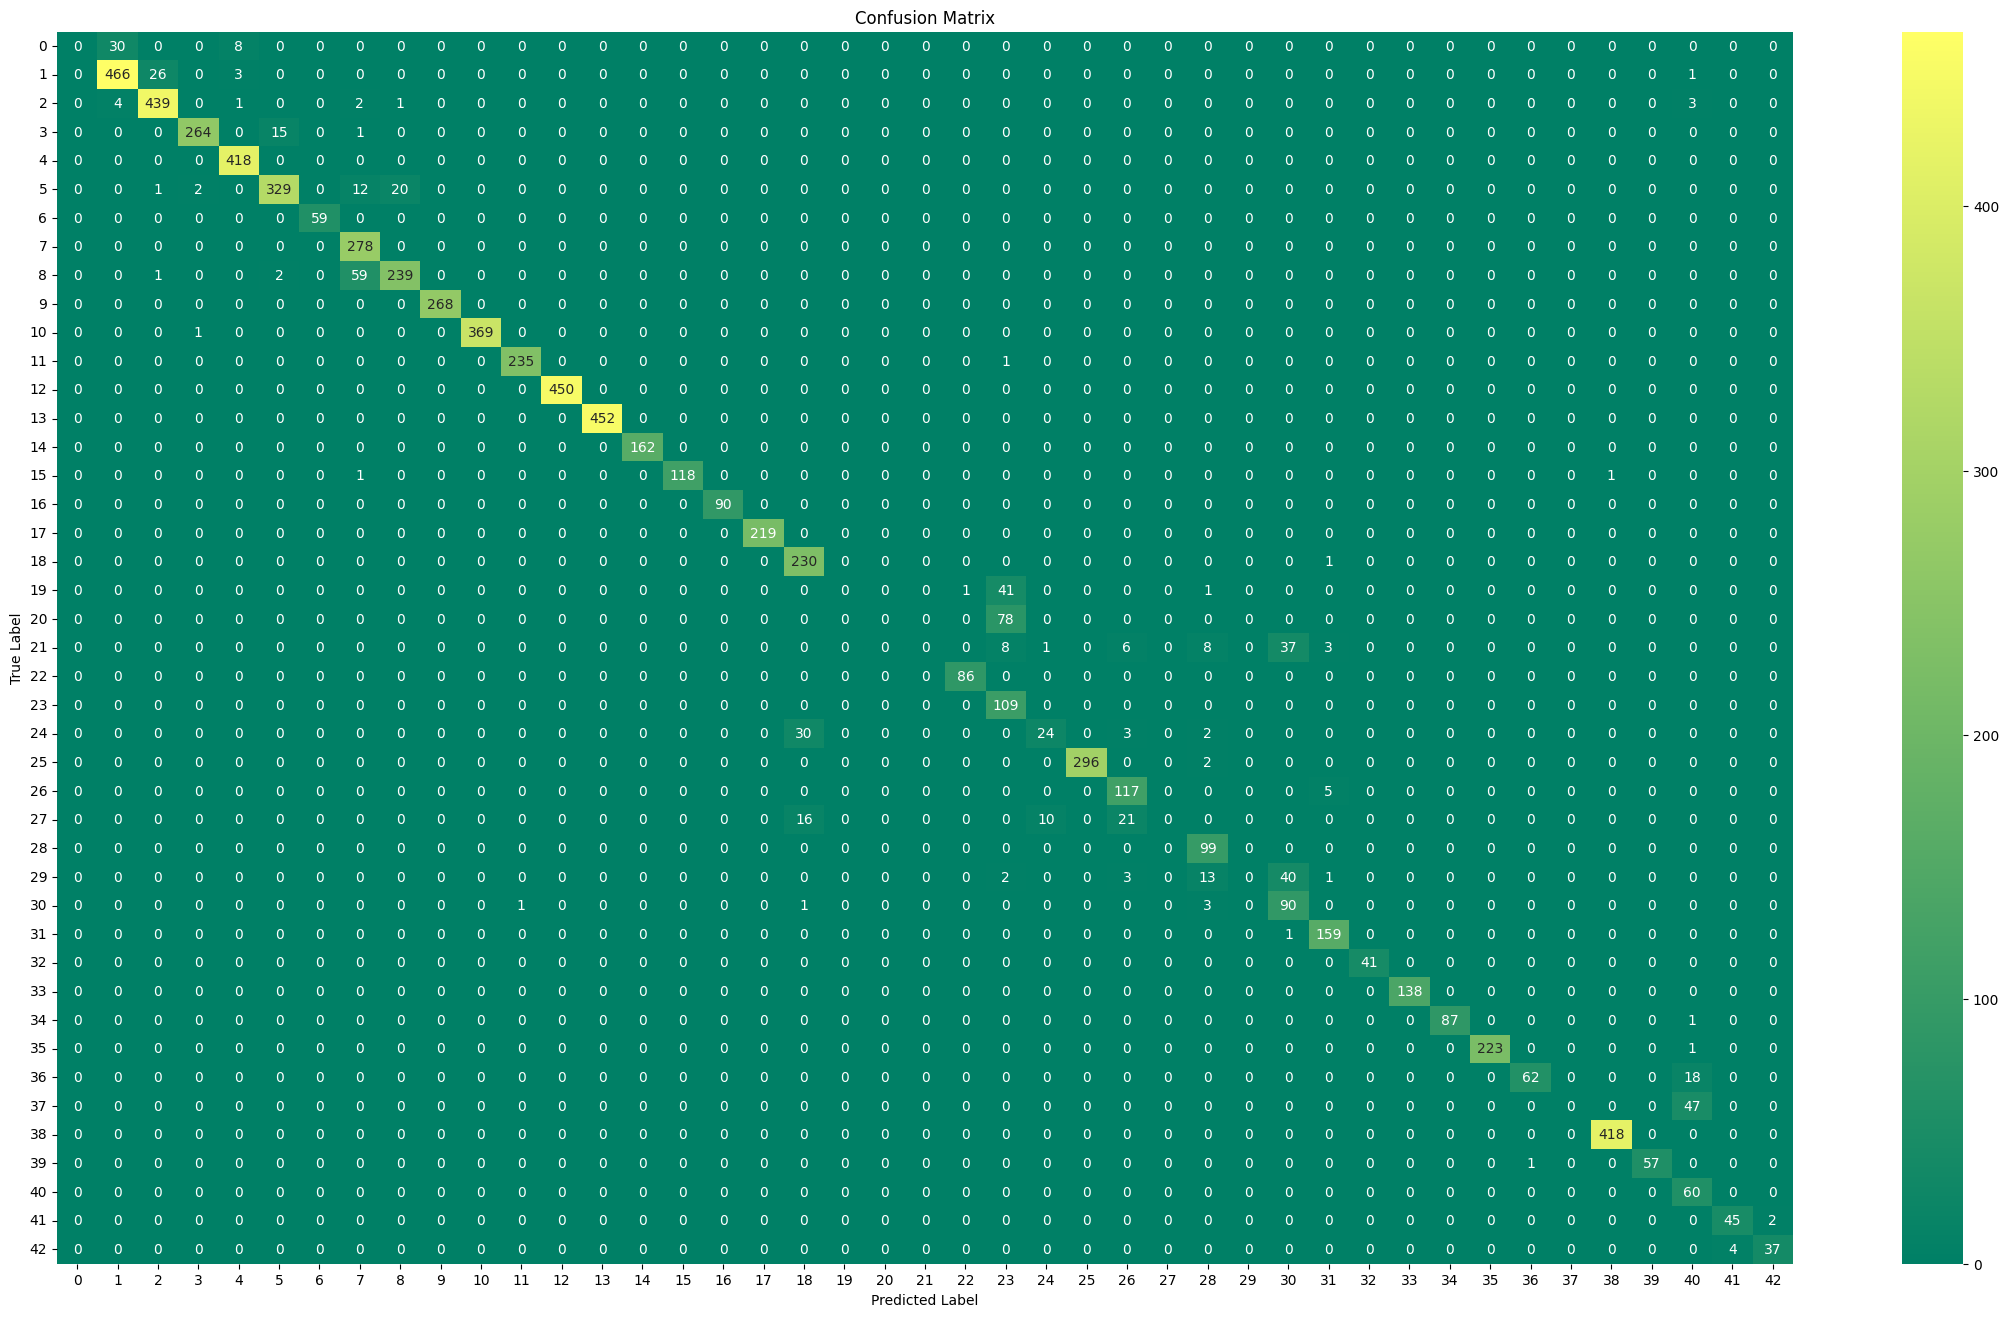

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get model predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize it using seaborn's heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='summer')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation = 0)
plt.title('Confusion Matrix')
plt.show()

##Classification Report

In [ ]:
# Get model predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.93      0.94      0.94       496
           2       0.94      0.98      0.96       450
           3       0.99      0.94      0.97       280
           4       0.97      1.00      0.99       418
           5       0.95      0.90      0.93       364
           6       1.00      1.00      1.00        59
           7       0.79      1.00      0.88       278
           8       0.92      0.79      0.85       301
           9       1.00      1.00      1.00       268
          10       1.00      1.00      1.00       370
          11       1.00      1.00      1.00       236
          12       1.00      1.00      1.00       450
          13       1.00      1.00      1.00       452
          14       1.00      1.00      1.00       162
          15       1.00      0.98      0.99       120
          16    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##ROC Curve and AUC

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
246/246 ━━━━━━

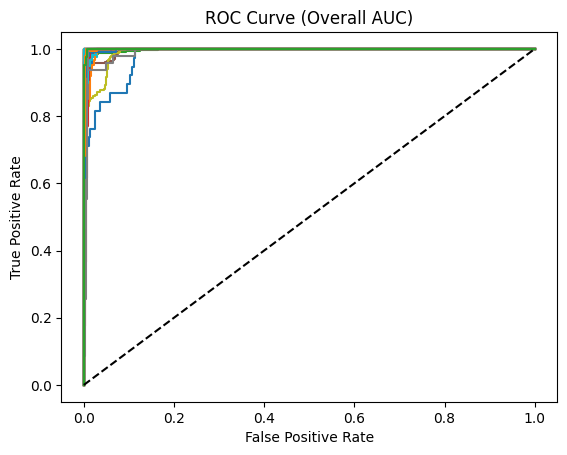

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Binarize labels for ROC computation
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# Initialize variables for micro-average and macro-average AUC
all_fpr = np.unique(np.concatenate([roc_curve(y_true_bin[:, i], model.predict(X_val)[:, i])[0] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)

# For macro-average AUC calculation
roc_aucs = []

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], model.predict(X_val)[:, i])
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)  # Store AUC for each class
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    # Interpolate the TPR to compute the micro-average
    mean_tpr += np.interp(all_fpr, fpr, tpr)  # Replaced with np.interp

# Add a diagonal line (Random Classifier)
plt.plot([0, 1], [0, 1], 'k--')

# Calculate the macro-average AUC
macro_auc = np.mean(roc_aucs)

# Calculate the micro-average AUC
mean_tpr /= num_classes
micro_auc = auc(all_fpr, mean_tpr)

# Plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Overall AUC)')
#plt.legend(loc='lower right')
plt.show()

In [ ]:
# Plot the micro-average ROC curve
#plt.plot(all_fpr, mean_tpr, color='red', linestyle='--', label=f'Micro-average (AUC = {micro_auc:.2f})')

print(f'Macro-average AUC: {macro_auc:.2f}')
print(f'Micro-average AUC: {micro_auc:.2f}')

Macro-average AUC: 1.00
Micro-average AUC: 1.00


##Evaluate on test data (unseen data)

In [ ]:
# Path to test CSV file
test_csv_path = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/GT-final_test.test.csv'
# Load the test labels from the CSV file
test_data = pd.read_csv(test_csv_path, sep=";")

In [ ]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


##Save test data

In [ ]:
# Create a DataFrame to save the image file names and predicted classes
result_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
result_df = result_df.sort_values(by='Filename')

# Save the results to a CSV file
result_df.to_csv('gtsrb_test_predictions.csv', index=False)
print("Predictions saved to 'gtsrb_test_predictions.csv'")

Predictions saved to 'gtsrb_test_predictions.csv'


##Print test accuracy

In [ ]:
import pandas as pd

# Load your predictions
predictions_df = pd.read_csv('gtsrb_test_predictions.csv')

# Load the ground truth file (downloaded separately)
ground_truth_df = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth_df[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 89.10%
